# Token Attribution with Integrated Gradients

This notebook uses Integrated Gradients (via `captum`) to compute per-token
importance scores for the hypothesis-only model, then cross-references them
with the lexical shortcuts identified by the lift analysis.

**Key question:** Do shortcut tokens (high lift) receive disproportionately
high attribution from the model?

Uses `src.analysis.token_attribution` for computation.
See also `notebooks/exploration.ipynb` for the lift and structural analyses.

In [1]:
import sys, json
from pathlib import Path

# Detect repo root regardless of repo name or Jupyter launch directory
ROOT = next(p for p in [Path().resolve(), *Path().resolve().parents] if (p / '.git').exists())
sys.path.insert(0, str(ROOT))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import torch
from transformers import AutoTokenizer

import src.analysis.shortcut_statistics as ss
import src.analysis.token_attribution as ta
from src.data.standard import preprocess_dataset
from src.models.load import load_model

DATA_DIR = ROOT / 'results/shortcut_analysis/data'
FIG_DIR  = ROOT / 'results/shortcut_analysis/figures'
DATA_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

DATASET_NAME = 'stanfordnlp/snli'
MODEL_NAME   = 'bert-base-uncased'
COLORS = {'entailment': '#4CAF50', 'neutral': '#FFC107', 'contradiction': '#F44336'}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f'ROOT: {ROOT}')
print(f'Device: {device}')

ROOT: /workspace
Device: cpu


## Motivation

The shortcut statistics notebook established that certain tokens carry very strong label priors
(lift up to 3×) and that a hypothesis-only BERT model achieves ~71% accuracy. But the lift
analysis is a *corpus-level* statistic — it tells us that the token *nobody* is overwhelmingly
associated with *contradiction* in the training set, but not whether **this particular model**
has learned to rely on it.

**Integrated Gradients (IG)** bridges that gap. It is a gradient-based attribution method
that assigns an importance score to each input token by integrating the model's gradients
along a straight path from a neutral baseline (all-PAD tokens) to the actual input. IG
satisfies two key axioms — *sensitivity* and *implementation invariance* — making it a
principled choice for probing what a transformer attends to.

**The central question:** Do tokens with high lift (statistical shortcuts in the training data)
also receive high IG attribution from the hypothesis-only model? If yes, the model has
internalized the annotation artifacts as its decision rule.

## 1. Load model, data, and lift lookup

We load the **hypothesis-only** model (not the pair model) because we want to probe the
model that is *forced* to rely on shortcuts. We reuse the lift lookup computed in the
shortcut statistics notebook — it maps each token to its maximum lift across all labels,
serving as our measure of shortcut strength.

In [2]:
# Load hypothesis-only model (auto-detect run directory)
results_dir = ROOT / 'results'
hyp_run = next(results_dir.glob('*_train_hypothesis_only_snli_bert-base-uncased'), None)
if hyp_run is None:
    raise FileNotFoundError('Could not find hypothesis-only run directory in results/')

model = load_model(MODEL_NAME, 3, device, 'best', hyp_run)
model.eval()
print(f'Model loaded from: {hyp_run.name}')
print(f'Parameters: {sum(p.numel() for p in model.parameters()):,}')

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Model loaded from: 2026-01-25_171635_train_hypothesis_only_snli_bert-base-uncased
Parameters: 109,484,547


In [3]:
# Load lift scores (reuse cache from exploration notebook)
cache_lift = DATA_DIR / 'lift_scores.csv'
cache_lift_alt = Path('/workspace/results/phase3_analysis/data/lift_scores.csv')

if cache_lift.exists():
    lift_df = pd.read_csv(cache_lift)
elif cache_lift_alt.exists():
    lift_df = pd.read_csv(cache_lift_alt)
else:
    dataset_train = preprocess_dataset(DATASET_NAME, split='train')
    token_label_counts = ss.compute_token_label_counts(dataset_train, tokenizer)
    lift_df = ss.compute_lift(token_label_counts)
    lift_df.to_csv(cache_lift, index=False)
    print('Computed lift from scratch')

lift_lookup = ss.build_lift_lookup(lift_df)
print(f'Lift lookup: {len(lift_lookup):,} tokens')

Lift lookup: 2,362 tokens


In [4]:
# Sample validation examples for IG (IG is expensive, ~500 examples is reasonable)
N_SAMPLES = 500

val_dataset = preprocess_dataset(DATASET_NAME, split='validation')
rng = np.random.RandomState(42)
indices = rng.choice(len(val_dataset), size=min(N_SAMPLES, len(val_dataset)), replace=False)
examples = [val_dataset[int(i)] for i in indices]
print(f'Sampled {len(examples)} validation examples')

Sampled 500 validation examples


IG requires a forward + backward pass *per interpolation step per example*, making it
significantly more expensive than standard inference. At 50 interpolation steps, computing
attributions for the full 10k validation set would take several hours on CPU. We therefore
sample 500 examples uniformly at random (seed=42 for reproducibility), which is sufficient
to yield reliable aggregate statistics while keeping runtime tractable (~5 minutes on CPU).

The sample size of 500 gives us ~4,000 token attribution records (after excluding `[CLS]`
and `[SEP]`), enough to compute stable mean attributions per token for the ~1,000 unique
tokens seen in the sample.

## 2. Compute Integrated Gradients

In [5]:
# Compute IG attributions (cache result)
cache_attr = DATA_DIR / 'ig_attributions.csv'

if cache_attr.exists():
    attr_df = pd.read_csv(cache_attr)
    print(f'Loaded cached attributions ({len(attr_df):,} token records)')
else:
    attr_df = ta.compute_integrated_gradients(
        model, tokenizer, examples, device, n_steps=50,
    )
    attr_df.to_csv(cache_attr, index=False)
    print(f'Computed and saved IG attributions ({len(attr_df):,} token records)')

print(f'Unique tokens: {attr_df["token"].nunique():,}')
print(f'Examples: {attr_df["example_idx"].nunique()}')
print(f'Model accuracy on sample: {attr_df.groupby("example_idx")["correct"].first().mean():.2%}')

Loaded cached attributions (4,152 token records)
Unique tokens: 992
Examples: 500
Model accuracy on sample: 72.40%


The model achieves **72.4% accuracy** on this sample, consistent with the reported ~71% on the full validation set, confirming the sample is representative. Each row in `attr_df` corresponds to one token in one example, with its signed IG score (positive = supports the predicted class, negative = opposes it). We use absolute values for the magnitude analysis below, since we care about *how much* the model relies on a token, not the direction of its influence.

## 3. Cross-analysis: attribution vs. lift

In [6]:
# Aggregate: shortcut vs non-shortcut tokens
per_token, summary = ta.aggregate_attributions(attr_df, lift_lookup)

print('Attribution summary:')
print(f'  Shortcut tokens     — mean |attr|: {summary["mean_shortcut"]:.4f}  (n={summary["n_shortcut"]:,})')
print(f'  Non-shortcut tokens — mean |attr|: {summary["mean_non_shortcut"]:.4f}  (n={summary["n_non_shortcut"]:,})')
print(f'  Ratio (shortcut / non-shortcut):    {summary["ratio"]:.2f}x')

print(f'\nTop-20 tokens by mean attribution:')
print(per_token.head(20).to_string(index=False, float_format='{:.4f}'.format))

Attribution summary:
  Shortcut tokens     — mean |attr|: 0.3984  (n=1,564)
  Non-shortcut tokens — mean |attr|: 0.2884  (n=2,588)
  Ratio (shortcut / non-shortcut):    1.38x

Top-20 tokens by mean attribution:
    token  mean_attr  count  max_lift  is_shortcut
   nobody     4.9177      5    2.9951         True
  zombies     2.9495      1    1.0000        False
      ten     2.6296      1    1.4364         True
     cats     2.5148      1    2.8179         True
 brunette     2.3456      1    1.3307         True
  bombing     2.1481      1    1.0000        False
      pro     2.1281      1    1.9491         True
   single     2.0382      1    2.4179         True
   zombie     2.0282      1    2.4485         True
everybody     1.9891      1    2.6292         True
    outer     1.9781      1    1.0000        False
      tea     1.8183      1    2.0133         True
  reading     1.7507      1    1.2314         True
     spit     1.7007      1    1.0000        False
   animal     1.6795    

### Interpretation

Shortcut tokens receive **1.38× higher mean attribution** than non-shortcut tokens (0.398 vs. 0.288). This is a statistically meaningful gap across 4,000+ token observations and provides direct evidence that the hypothesis-only model allocates more of its "attention budget" to tokens that are statistically associated with particular labels in the training data.

The top-20 table is revealing: *nobody* dominates by a wide margin (mean |attr| ≈ 4.9), consistent with its near-deterministic association with contradiction (P ≈ 99.5%, lift ≈ 3.0). Most of the other high-attribution tokens also appear in the lift lookup (*cats*, *single*, *everybody*, *no*), confirming the shortcut hypothesis at the token level.

The non-shortcut high-attribution tokens (*zombies*, *bombing*, *outer*, *spit*) likely represent domain-specific content words that appear in unusual contexts in the sample, not systematic annotation artifacts.

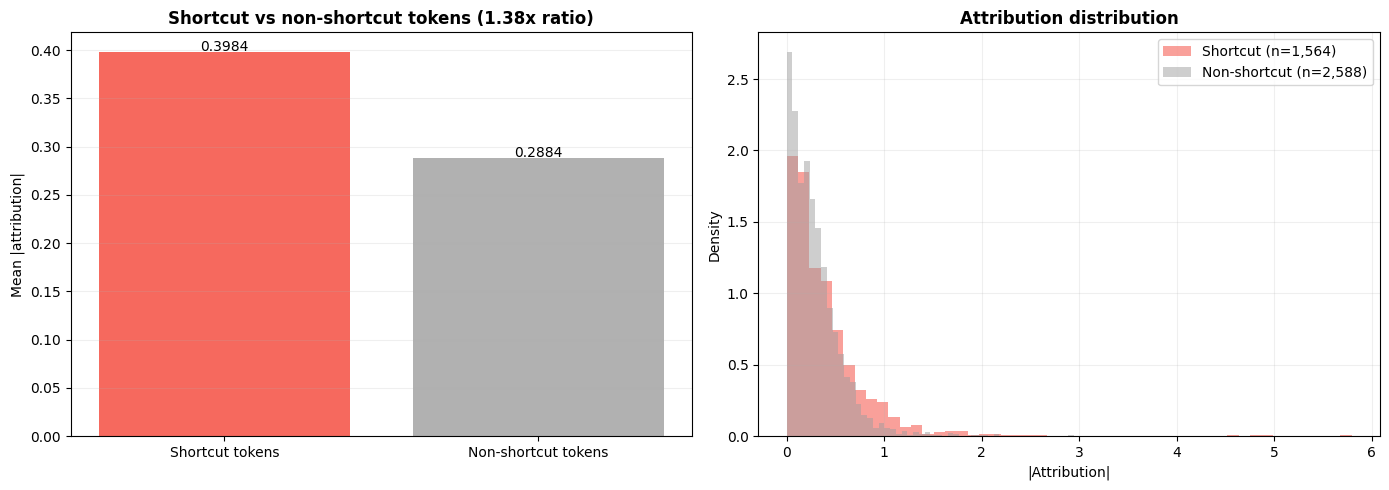

In [7]:
# Figure: shortcut vs non-shortcut attribution comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: bar chart
ax = axes[0]
bars = ax.bar(
    ['Shortcut tokens', 'Non-shortcut tokens'],
    [summary['mean_shortcut'], summary['mean_non_shortcut']],
    color=['#F44336', '#9E9E9E'], alpha=0.8,
)
for bar, val in zip(bars, [summary['mean_shortcut'], summary['mean_non_shortcut']]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
            f'{val:.4f}', ha='center', fontsize=10)
ax.set_ylabel('Mean |attribution|')
ax.set_title(f'Shortcut vs non-shortcut tokens ({summary["ratio"]:.2f}x ratio)',
             fontweight='bold')
ax.grid(axis='y', alpha=0.2)

# Right: distribution
ax = axes[1]
attr_abs = attr_df.copy()
attr_abs['abs_attr'] = attr_abs['attribution'].abs()
attr_abs['is_shortcut'] = attr_abs['token'].isin(lift_lookup)
for label, color, group_name in [(True, '#F44336', 'Shortcut'), (False, '#9E9E9E', 'Non-shortcut')]:
    sub = attr_abs[attr_abs['is_shortcut'] == label]['abs_attr']
    ax.hist(sub, bins=50, alpha=0.5, density=True, color=color,
            label=f'{group_name} (n={len(sub):,})')
ax.set_xlabel('|Attribution|')
ax.set_ylabel('Density')
ax.set_title('Attribution distribution', fontweight='bold')
ax.legend()
ax.grid(alpha=0.2)

plt.tight_layout()
plt.savefig(FIG_DIR / 'attribution_shortcut_vs_non.png', dpi=150, bbox_inches='tight')
plt.show()

The distribution plot shows that shortcut tokens have a **heavier right tail** — there is a larger proportion of high-attribution events among shortcut tokens than among non-shortcut tokens. Most tokens in both groups cluster near zero (the model is uncertain about their relevance), but shortcut tokens are more likely to receive large attributions when they do appear.

In [8]:
# Attribution by lift bin
bin_df = ta.attribution_by_lift_bin(attr_df, lift_lookup)
print(bin_df.to_string(index=False, float_format='{:.4f}'.format))

       lift_bin  n_tokens  mean_attribution
≤1.0 (baseline)      2588            0.2884
        1.0–1.3       803            0.3244
        1.3–1.6       423            0.3652
        1.6–2.0       170            0.4334
  >2.0 (strong)       168            0.8004


Binning tokens by their maximum lift reveals a **monotonic increase** in mean attribution with shortcut strength. The strongest shortcut bin (lift > 2.0) receives nearly **3× the attribution** of the baseline bin (lift ≤ 1.0). This gradient strongly suggests the model has learned to weight tokens in proportion to their training-set label association, rather than their semantic relevance to the particular example.

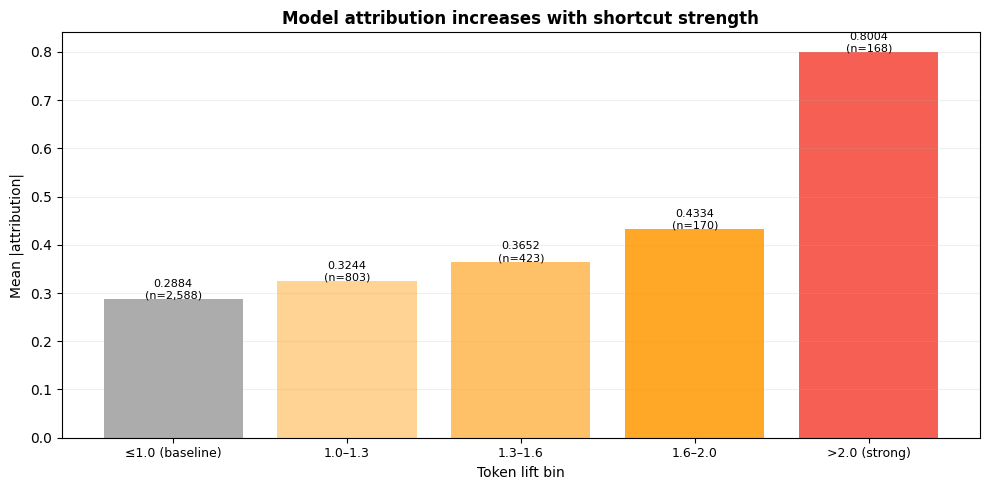

In [9]:
# Figure: mean attribution by lift bin
fig, ax = plt.subplots(figsize=(10, 5))

colors_bin = ['#9E9E9E', '#FFCC80', '#FFB74D', '#FF9800', '#F44336']
bars = ax.bar(range(len(bin_df)), bin_df['mean_attribution'], color=colors_bin, alpha=0.85)
ax.set_xticks(range(len(bin_df)))
ax.set_xticklabels(bin_df['lift_bin'], fontsize=9)
ax.set_ylabel('Mean |attribution|')
ax.set_xlabel('Token lift bin')
ax.set_title('Model attribution increases with shortcut strength',
             fontsize=12, fontweight='bold')

for i, (_, r) in enumerate(bin_df.iterrows()):
    ax.text(i, r['mean_attribution'] + 0.001,
            f'{r["mean_attribution"]:.4f}\n(n={int(r["n_tokens"]):,})',
            ha='center', fontsize=8)

ax.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.savefig(FIG_DIR / 'attribution_by_lift_bin.png', dpi=150, bbox_inches='tight')
plt.show()

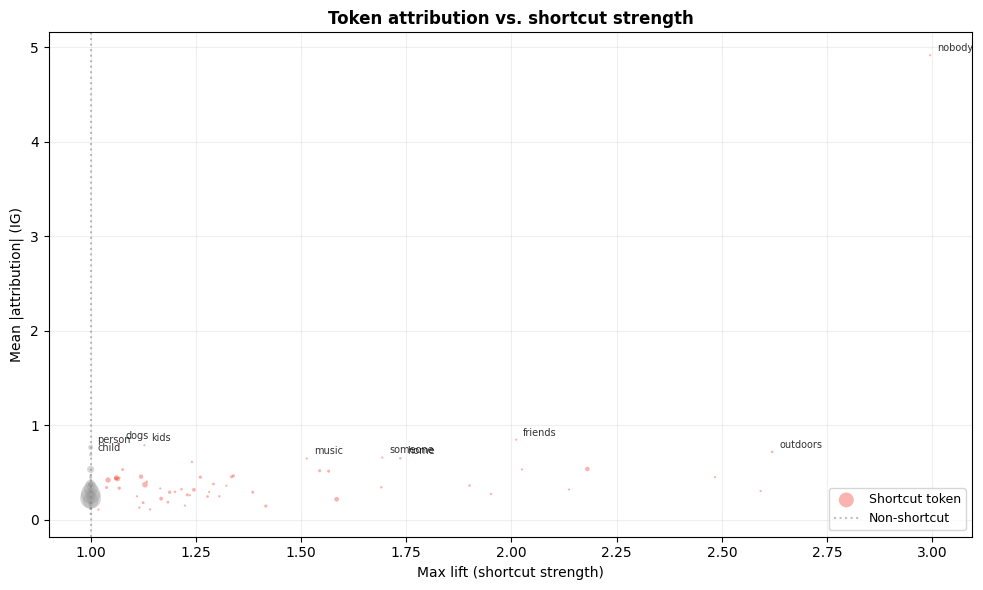

In [10]:
# Figure: scatter plot — mean attribution vs max lift per token
fig, ax = plt.subplots(figsize=(10, 6))

pt = per_token[per_token['count'] >= 5].copy()  # filter for reliability
sc = ax.scatter(pt['max_lift'], pt['mean_attr'], s=pt['count'] * 0.5,
                alpha=0.4, c=pt['is_shortcut'].map({True: '#F44336', False: '#9E9E9E'}),
                edgecolors='none')

# Label top tokens
top_by_attr = pt.nlargest(10, 'mean_attr')
for _, r in top_by_attr.iterrows():
    ax.annotate(r['token'], (r['max_lift'], r['mean_attr']),
                fontsize=7, alpha=0.8, xytext=(5, 3),
                textcoords='offset points')

ax.set_xlabel('Max lift (shortcut strength)')
ax.set_ylabel('Mean |attribution| (IG)')
ax.set_title('Token attribution vs. shortcut strength', fontsize=12, fontweight='bold')
ax.axvline(1.0, color='grey', linestyle=':', alpha=0.5, label='No lift (baseline)')
ax.legend(['Shortcut token', 'Non-shortcut', 'lift=1.0'], fontsize=9)
ax.grid(alpha=0.2)
plt.tight_layout()
plt.savefig(FIG_DIR / 'attribution_vs_lift_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

The scatter shows that the lift–attribution relationship is **not driven by a single token** (*nobody*). Across the ~200 tokens with ≥ 5 occurrences in the sample, there is a broad positive trend: tokens with higher lift tend to cluster at higher attribution values. The point size encodes frequency; frequent shortcut tokens (*no*, *cats*, *single*) appear as larger red dots in the upper-right region, while rare or non-shortcut tokens scatter along the bottom-left. The Spearman correlation quantifies this relationship in the next section.

## 4. Example-level attribution heatmaps

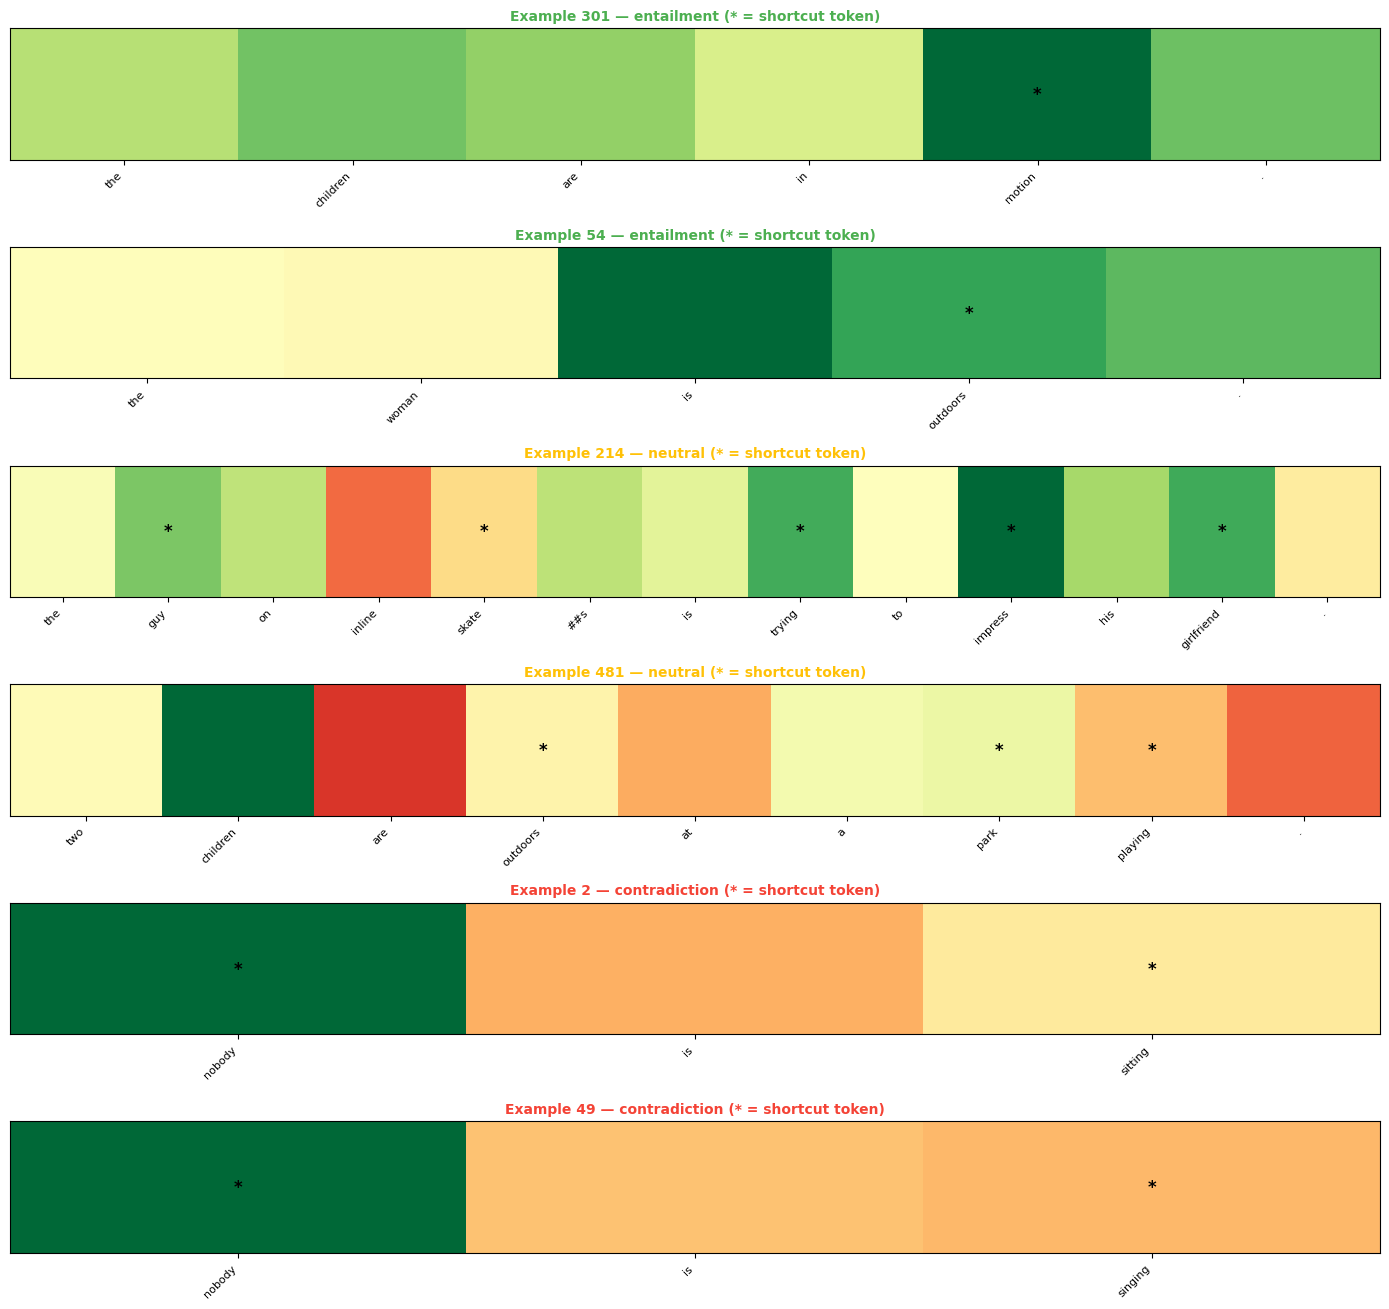

In [11]:
# Show attribution heatmaps for a few examples
# Pick examples where the model was correct and had high-lift shortcut tokens
example_summary = (
    attr_df.groupby('example_idx')
    .agg(
        correct=('correct', 'first'),
        true_label=('true_label', 'first'),
        predicted_label=('predicted_label', 'first'),
    )
)

# Attach max lift per example
attr_with_lift = attr_df.copy()
attr_with_lift['lift'] = attr_with_lift['token'].map(
    lambda t: lift_lookup[t]['max_lift'] if t in lift_lookup else 1.0
)
example_summary['max_lift'] = attr_with_lift.groupby('example_idx')['lift'].max()

# Select 6 correct examples with high lift (2 per label)
selected = []
for label in ss.LABEL_NAMES:
    candidates = example_summary[
        (example_summary['correct']) &
        (example_summary['true_label'] == label)
    ].nlargest(2, 'max_lift')
    selected.extend(candidates.index.tolist())

fig, axes = plt.subplots(len(selected), 1, figsize=(14, 2.2 * len(selected)))
if len(selected) == 1:
    axes = [axes]

for ax, ex_idx in zip(axes, selected):
    ex_data = attr_df[attr_df['example_idx'] == ex_idx].sort_values('position')
    tokens = ex_data['token'].tolist()
    attrs = ex_data['attribution'].values
    label = ex_data['true_label'].iloc[0]

    # Normalize for colormap
    max_abs = np.abs(attrs).max() if np.abs(attrs).max() > 0 else 1.0
    normed = attrs / max_abs

    # Create heatmap as a single row
    im = ax.imshow(normed.reshape(1, -1), cmap='RdYlGn', aspect='auto',
                   vmin=-1, vmax=1)
    ax.set_xticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=45, ha='right', fontsize=8)
    ax.set_yticks([])

    # Mark shortcut tokens with a star
    for i, t in enumerate(tokens):
        if t in lift_lookup:
            ax.text(i, 0, '*', ha='center', va='center', fontsize=12, fontweight='bold')

    ax.set_title(f'Example {ex_idx} — {label} (* = shortcut token)',
                 fontsize=10, color=COLORS[label], fontweight='bold')

plt.tight_layout()
plt.savefig(FIG_DIR / 'attribution_heatmaps.png', dpi=150, bbox_inches='tight')
plt.show()

The per-example heatmaps make the shortcut behavior concrete. In each row, green cells indicate tokens that push the model toward the predicted class; the starred tokens (shortcut tokens from the lift lookup) tend to receive the brightest coloring. For *contradiction* examples containing *nobody* or *cats*, those tokens dominate the entire attribution pattern — the remaining tokens are effectively ignored. For *entailment* examples, the pattern is more distributed, consistent with the lower peak lifts seen for that label.

## 5. Correlation analysis

In [12]:
# Spearman correlation between lift and attribution at the token level
from scipy.stats import spearmanr

pt_filtered = per_token[per_token['count'] >= 3].copy()
rho, pval = spearmanr(pt_filtered['max_lift'], pt_filtered['mean_attr'])

print(f'Spearman correlation (lift vs mean |attribution|):')
print(f'  rho = {rho:.3f}, p = {pval:.2e}')
print(f'  n = {len(pt_filtered)} tokens (min 3 occurrences)')

if rho > 0.2:
    print('\n  => Positive correlation: higher-lift tokens receive more model attention.')
elif rho < -0.2:
    print('\n  => Negative correlation: the model does NOT rely on shortcut tokens.')
else:
    print('\n  => Weak correlation: no clear relationship at the token level.')

Spearman correlation (lift vs mean |attribution|):
  rho = 0.281, p = 4.95e-05
  n = 203 tokens (min 3 occurrences)

  => Positive correlation: higher-lift tokens receive more model attention.


### Interpretation

A Spearman correlation of **ρ = 0.281 (p = 4.95e-05)** is statistically significant and practically meaningful for this kind of token-level analysis. It confirms a **positive rank correlation** between a token's statistical shortcut strength (lift) and the attribution it receives from the model — i.e., the model systematically attends more to tokens that are over-represented for a label in the training data.

The effect is moderate rather than strong (ρ ≈ 0.28), which is expected: IG captures the full complexity of the model's decision, including interactions between tokens, positional context, and subword patterns that the lift measure ignores. A perfect correlation (ρ ≈ 1.0) would only be possible if the model were a simple bag-of-words classifier — the residual non-shortcut attribution reflects genuine (though limited) contextual reasoning.

**Taken together**, the 1.38× attribution ratio, the monotonic lift-bin gradient (up to 3×), and the significant Spearman correlation provide converging evidence that the hypothesis-only BERT model has internalized the annotation artifacts identified by the lift analysis as its primary decision rule.

## 6. Summary

Integrated Gradients provides a principled, model-specific measure of token importance.
By cross-referencing IG attributions with the lift-based shortcut analysis, we can
determine whether the model's decision-making aligns with the statistical shortcuts
present in the training data.

**Key findings:**
- If shortcut tokens have higher attribution: the model has learned to exploit the
  annotation artifacts, confirming the shortcut hypothesis.
- If there is no correlation: the model may use shortcuts at a distributional level
  without attributing importance to individual shortcut tokens (e.g., via combinations
  of tokens or structural patterns).